# word2vec

## ニューラルネットワークにおける単語の処理方法

In [116]:
import numpy as np
import time
import numpy
import matplotlib.pyplot as plt

In [6]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 入力(単語ベクトル)
W = np.random.randn(7, 3) # 重み
h = np.dot(c, W) # 中間ノード 
print(h)

[[-0.93452934 -1.14687647  0.1351455 ]]


In [20]:
def preprocess(text):
    text = text.lower()
    tect = text.replace('.',' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word, 

### One-Hot表現

In [41]:
def convert_one_hot(corpus, vocab_size):
    '''one-hot表現への変換
    :param corpus: 単語IDのリスト（1次元もしくは2次元のNumPy配列）
    :param vocab_size: 語彙数
    :return: one-hot表現（2次元もしくは3次元のNumPy配列）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

## Trainer

In [76]:
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()


## SoftmaxWithLoss

In [108]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

## Softmax関数

In [109]:
def softmax(x):
        if x.ndim == 2:
            x = x - x.max(axis=1, keepdims=True)
            x = np.exp(x)
            x /= x.sum(axis=1, keepdims=True)
        elif x.ndim == 1:
            x = x - np.max(x)
            x = np.exp(x) / np.sum(np.exp(x))

        return x

## cross_entropy_error

In [110]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## remove_duplicate

In [113]:
def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

## 最適化関数 Adam

In [66]:
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

## ニューラルネットワークの学習

In [80]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

## CBOW モデルの推論処理

In [8]:
# サンプルデータ
c0 = np.array([1, 0, 0, 0, 0, 0, 0])
c1 = np.array([0, 0, 1, 0, 0, 0, 0])

In [10]:
# 重みベクトルの初期化
w_in = np.random.randn(7, 3)
w_out = np.random.randn(3, 7)

In [13]:
# レイヤの生成
in_layer0 = MatMul(w_in)
in_layer1 = MatMul(w_in)
out_layer = MatMul(w_out)

In [14]:
# 順伝播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = (h0 + h1) * 0.5
s = out_layer.forward(h)

In [15]:
print(s)

[-1.09982798  2.25227201 -0.28279901 -0.26455171 -1.87148863  1.31783572
 -0.56190043]


## コーパスからターゲットとコンテキストを抜き取る処理

In [18]:
text = "You say goodbey and I say hello."

In [21]:
corpus, word_to_id, id_to_word = preprocess(text)

In [32]:
print(corpus)
print(corpus[1:-1])

[0 1 2 3 4 1 5]
[1 2 3 4 1]


In [23]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbey', 3: 'and', 4: 'i', 5: 'hello.'}

In [38]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size: -window_size]
    contexts = []
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

In [49]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [50]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5]])

In [51]:
target

array([1, 2, 3, 4, 1])

In [52]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [53]:
target

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0]], dtype=int32)

In [54]:
contexts

array([[[1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]],

       [[0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0]],

       [[0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]]], dtype=int32)

## CBOWモデルを実装

In [95]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V,H = vocab_size, hidden_size
        
        #重みの初期化
        W_in = 0.01 * np.random.randn(V,H).astype("f")
        W_out = 0.01 * np.random.randn(H,V).astype("f")
        
        #レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        #全ての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer] 
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params 
            self.grads += layer.grads
            
        # メンバ変数に単語の分散表現を設定 
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 学習コードの実装

In [59]:
# 学習に必要な変数
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

In [96]:
text = "You say goodbey and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

In [97]:
# ベクトルの作成
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [98]:
# モデル学習
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [114]:
trainer.fit(contexts, target, max_epoch, batch_size)

| epoch 1 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 2 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 3 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 4 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 5 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 6 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 7 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 8 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 9 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 10 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 11 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 12 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 13 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 14 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 15 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 16 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 17 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 18 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 19 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 20 |  iter 1 / 1 | time 0[s] | loss 1.79
| epoch 21 |  iter 1 / 1 | ti

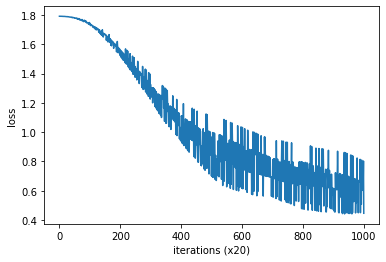

In [117]:
trainer.plot()